In [125]:
import pandas as pd

In [126]:
df = pd.read_csv("data/pump_heatsink_modelling.csv")
COLS = df.columns
df.head()

,Time,Heatsink Temp.,Speed [RPM],Motor Voltage,Motor current
0,2022-02-04 11:26:42,31.0,0.0,0.0,0.0
1,2022-02-04 11:26:52,31.0,0.0,0.0,0.0
2,2022-02-04 11:27:02,31.0,0.0,0.0,0.0
3,2022-02-04 11:27:12,31.0,0.0,0.0,0.0
4,2022-02-04 11:27:22,31.0,0.0,0.0,0.0


In [127]:
from sklearn.preprocessing import StandardScaler
time_col = df["Time"]
df = df.drop('Time', axis=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

In [128]:
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler

fig = FigureWidgetResampler(go.Figure())
fig.update_layout(margin=dict(l=10, r=10, t=10, b=10))
fig.add_trace(go.Scattergl(name=r'Temperature', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['Heatsink Temp.'])
fig.add_trace(go.Scattergl(name=r'Motor Current', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['Motor current'])
fig.add_trace(go.Scattergl(name=r'Motor Voltage', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['Motor Voltage'])
fig.add_trace(go.Scattergl(name=r'Speed', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['Speed [RPM]'])
fig.update_layout(height=400, template="plotly_dark")
display(fig)

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> Temperature <i style="color:#fc9944">~1</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '0d547252-9b1c-4981-96c5-79902c7e660a',
              'x': array([   0,    1,    2, ..., 1126, 1127, 1129]),
              'y': array([-1.44317317, -1.44317317, -1.44317317, ..., -1.44317317, -1.44317317,
                          -1.44317317])},
             {'name': ('<b style="color:sandybrown">[R' ... 'i style="color:#fc9944">~1</i>'),
              'showlegend': True,
              'type': 'scattergl',
              'uid': '44193fdb-2edb-47f7-9a41-bc8a6f19fb3a',
              'x': array([   0,    1,    2, ..., 1126, 1127, 1129]),
              'y': array([-1.35322359, -1.35322359, -1.35322359, ..., -1.35322359, -1.35322359,
                          -1.35322359])},
             {'name': ('<b style="color:sandybrown">[R' ... 'i style="color:#fc9944">~1</i>'),
       

In [129]:
import matplotlib.pyplot as plt
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.general_estimators import NARX
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)


In [130]:
train_split_size = 0.7

train_df = df_scaled[:int(train_split_size*len(df_scaled))]
test_df = df_scaled[int(train_split_size*len(df_scaled)):]

FEATURES = ['Speed [RPM]', 'Motor current']
TARGET = 'Heatsink Temp.'

x_train, y_train = train_df[FEATURES].values, train_df[TARGET].values
x_test, y_test= test_df[FEATURES].values, test_df[TARGET].values

In [138]:
from sysidentpy.general_estimators import NARX

basis_function = Fourier(degree=1)

catboost_narx = NARX(
    base_estimator=CatBoostRegressor(iterations=600, learning_rate=0.3, depth=8),
    xlag=[[2], [2]],
    ylag=2,
    basis_function=basis_function,
    model_type="NARMAX",
    fit_params={"verbose": False},
)

catboost_narx.fit(X=x_train, y=y_train.reshape(-1,1))

In [139]:
yhat = catboost_narx.predict(X=x_test, y=y_test.reshape(-1,1), steps_ahead=1)
print("MSE: ", mean_squared_error(y_test, yhat))

MSE:  1.5991334603219207


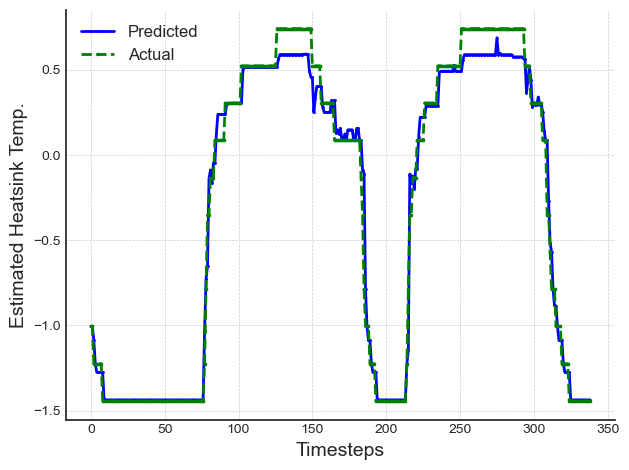

In [140]:
import matplotlib.pyplot as plt 
plt.plot(yhat, color='blue', linestyle='-', linewidth=2, marker='o', markersize=1, label='Predicted')
plt.plot(y_test, color='green', linestyle='--', linewidth=2, marker='s', markersize=1.5, label='Actual')
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Estimated Heatsink Temp.', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the margins and layout
plt.tight_layout()

# Show the plot
plt.show()

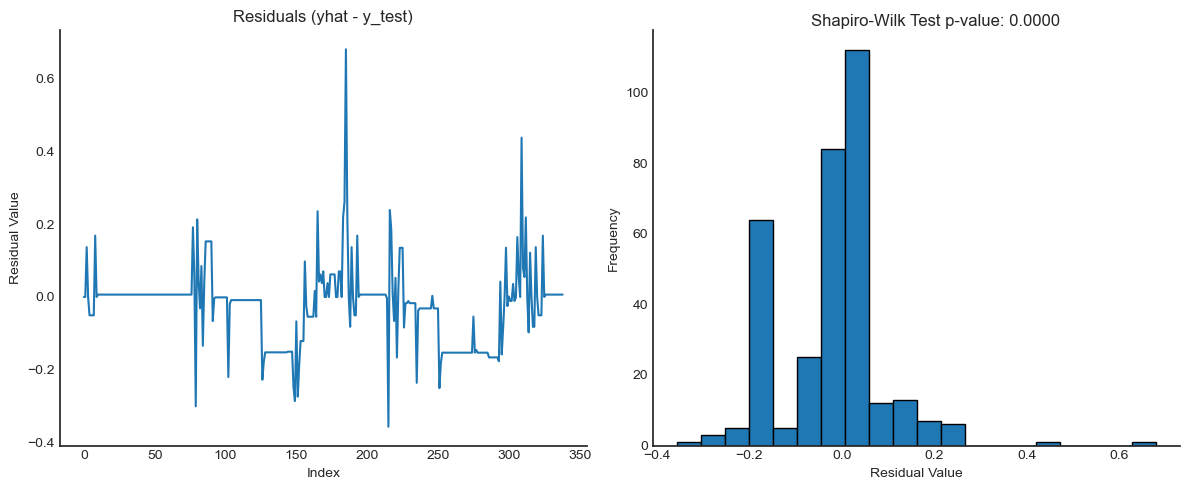

Shapiro-Wilk Test result:
Statistic: 0.8621, p-value: 0.0000


In [141]:
from scipy.stats import shapiro


residuals = yhat.squeeze() - y_test

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Plot of residuals
axs[0].plot(residuals)
axs[0].set_title('Residuals (yhat - y_test)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Residual Value')

# Second subplot: Histogram of residuals
axs[1].hist(residuals, bins=20, edgecolor='black')
axs[1].set_xlabel('Residual Value')
axs[1].set_ylabel('Frequency')

# Perform Shapiro-Wilk Test for normality
stat, p = shapiro(residuals)
axs[1].annotate(f'Shapiro-Wilk Test p-value: {p:.4f}', xy=(0.3, 1.01), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

# Print Shapiro-Wilk Test result
print("Shapiro-Wilk Test result:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

In [142]:
alpha = 0.05  # significance level
if p > alpha:
    print("The Shapiro-Wilk test is successful: the data follows a normal distribution.")
else:
    print("The Shapiro-Wilk test is unsuccessful: the data does not follow a normal distribution.")
    

The Shapiro-Wilk test is unsuccessful: the data does not follow a normal distribution.
